# Short_range National Water Model Forecast
### Workflow for creating an 18 hour stream flow forecast given a date, time, and NHDplus COMID (stream segment identifier)

In [1]:
import sys; sys.path.append('..')
from fcast import ShortRange, Assim, get_USGS_rc, plotShortRange
import gcsfs
%matplotlib inline

## Set up the Google Cloud File System

In [2]:
fs = gcsfs.GCSFileSystem(project='national-water-model')

## Set the parameters

In [3]:
date = '20190802' # a date
start_hr = '00' # start at 00:00 because its easy at the moment
comid = 4512772 # some small segment on the Potomac near DC
# comid = 229757 # the South Platte River in Denver
# comid = 7471678 # somewhere on the Mississippi River

## Get short range streamflow forecast

In [4]:
sim = Assim(fs, comid, date, start_hr)
sr = ShortRange(fs, comid, date, start_hr)
sr_df = sr.get_streamflow(sim.assim_time, sim.assim_flow)
sr_df.head()

,streamflow
2019-08-02 00:00:00,112.699997
2019-08-02 01:00:00,119.389997
2019-08-02 02:00:00,124.859997
2019-08-02 03:00:00,129.759997
2019-08-02 04:00:00,133.689997


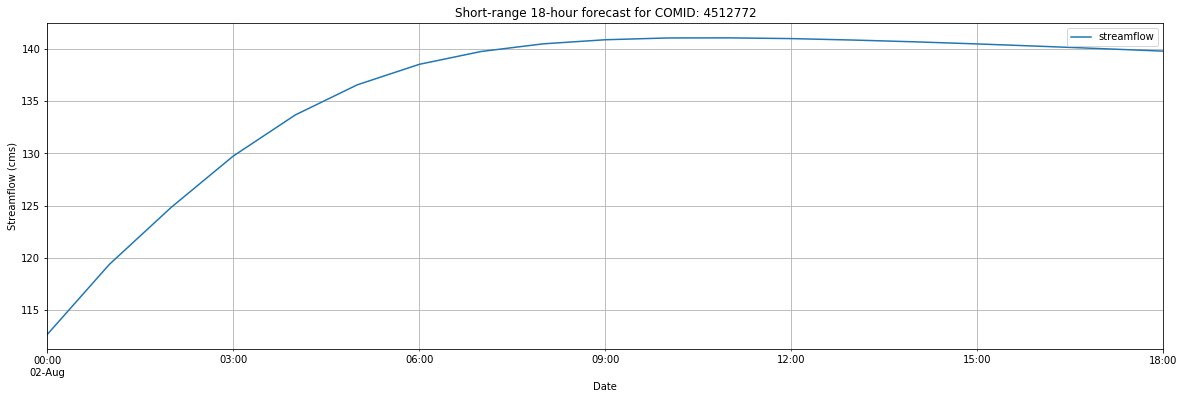

In [5]:
plotShortRange(sr_df, comid)

# Convert Flow to Stage

In [6]:
f, rc_df = sr.get_NWM_rc()
rc_df.head()

,Stage,Discharge
0,0.0000,0.000000
1,0.3048,30.085741
2,0.6096,96.720480
3,0.9144,180.899337
4,1.2192,323.340296


## Apply the NWM rating curve and convert from streamflow to stage

In [7]:
stage_df = sr_df.apply(f).rename(columns={'streamflow': 'stage'})

## Plot the forecasted stage depth

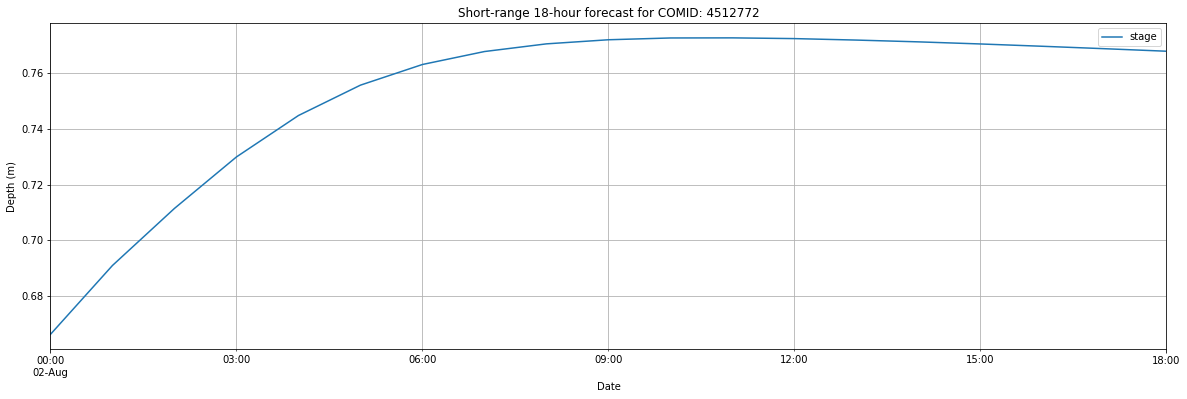

In [8]:
plotShortRange(stage_df, comid, flow=False)

# Compare NWM rating curve with the USGS rating curve

In [9]:
USGS_rcs = get_USGS_rc(comid)
print(USGS_rcs[0])
USGS_rcs[1].head()

No rating curve available, please set `get_rc` = False for station 01646502


,INDEP,SHIFT,DEP,INDEP_SHIFT,INDEP_m,SHIFT_m,DEP_cms,INDEP_SHIFT_m
0,2.01,0.0,223.00,2.01,0.612648,0.0,6.314657,0.612648
1,2.02,0.0,226.14,2.02,0.615696,0.0,6.403572,0.615696
2,2.03,0.0,228.00,2.03,0.618744,0.0,6.456241,0.618744
3,2.04,0.0,230.80,2.04,0.621792,0.0,6.535528,0.621792
4,2.05,0.0,233.00,2.05,0.624840,0.0,6.597825,0.624840


## Apply it to the stream flow data to convert it to stage

In [10]:
stage_df_usgs = sr_df.apply(USGS_rcs[0]).rename(columns={'streamflow': 'stage_usgs'})
stage_df_usgs.head()

,stage_usgs
2019-08-02 00:00:00,0.975155
2019-08-02 01:00:00,0.986826
2019-08-02 02:00:00,0.996148
2019-08-02 03:00:00,1.004343
2019-08-02 04:00:00,1.010814


## Plot them and compare

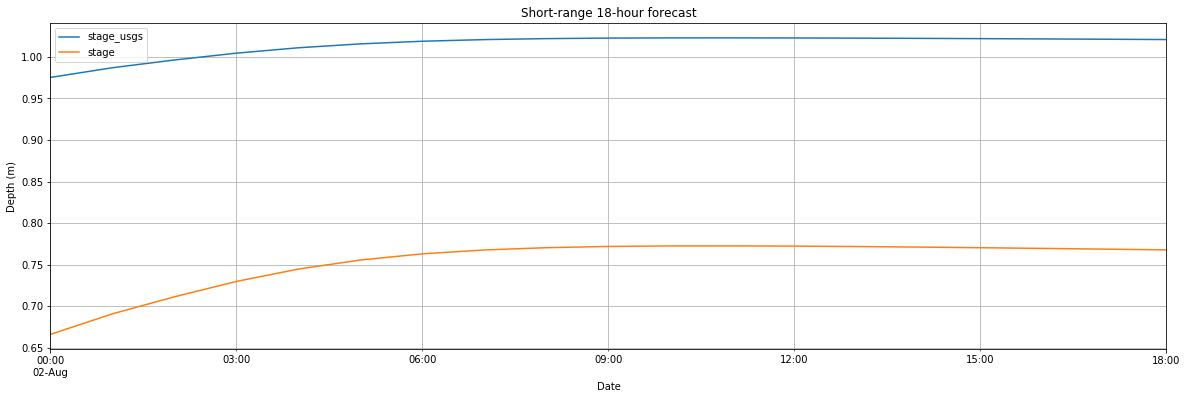

In [11]:
ax1 = stage_df_usgs.plot(figsize=(20,6), title='Short-range 18-hour forecast')
ax = stage_df.plot(ax=ax1, figsize=(20,6), title='Short-range 18-hour forecast')
ax.grid(True, which="both")
ax.set(xlabel='Date', ylabel='Depth (m)');

# USGS rating curve equates to a higher stage than the NWM rating curve